# Decision Tree Classification — Complete Assignment Notebook

**Dataset path (local):** `D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree\heart_disease.xlsx`

**Objective:** Apply Decision Tree Classification to the given dataset, evaluate performance, perform hyperparameter tuning, and interpret results. This notebook follows the assignment tasks and includes markdown answers to the interview questions.

---

## 1) Data Preparation
Load the dataset and inspect basic info.

In [1]:
# 1) Data Preparation
import os, pandas as pd, numpy as np
DATA_DIR = r"D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree"
file_path = os.path.join(DATA_DIR, "heart_disease.xlsx")

# Fallback to sandbox path if running here
if not os.path.exists(file_path):
    file_path = "/mnt/data/heart_disease.xlsx"

print("Loading data from:", file_path)
df = pd.read_excel(file_path)
print("Shape:", df.shape)
display(df.head())


Loading data from: D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree\heart_disease.xlsx
Shape: (908, 13)


age   sex               cp  trestbps  chol    fbs         restecg  thalch  \
0   63  Male   typical angina       145   233   True  lv hypertrophy     150   
1   41  Male  atypical angina       135   203  False          normal     132   
2   57  Male     asymptomatic       140   192  False          normal     148   
3   52  Male   typical angina       118   186  False  lv hypertrophy     190   
4   57  Male     asymptomatic       110   201  False          normal     126   

   exang  oldpeak        slope          thal  num  
0  False      2.3  downsloping  fixed defect    0  
1  False      0.0         flat  fixed defect    0  
2  False      0.4         flat  fixed defect    0  
3  False      0.0         flat  fixed defect    0  
4   True      1.5         flat  fixed defect    0

## 2) Exploratory Data Analysis (EDA)
Check missing values, outliers, distributions, and correlations. Visualize using histograms, boxplots, and a correlation heatmap.

Data types:
 age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs            bool
restecg      object
thalch        int64
exang        object
oldpeak     float64
slope        object
thal         object
num           int64
dtype: object

Missing values per column:
 age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalch       0
exang        0
oldpeak     62
slope        0
thal         0
num          0
dtype: int64


count unique           top freq        mean         std   min  \
age       908.0    NaN           NaN  NaN    53.79185    9.158031  29.0   
sex         908      2          Male  718         NaN         NaN   NaN   
cp          908      4  asymptomatic  495         NaN         NaN   NaN   
trestbps  908.0    NaN           NaN  NaN  133.430617   20.401608   0.0   
chol      908.0    NaN           NaN  NaN  201.484581  112.097949   0.0   
fbs         908      2         False  723         NaN         NaN   NaN   
restecg     908      3        normal  542         NaN         NaN   NaN   
thalch    908.0    NaN           NaN  NaN  135.957048   26.804929  60.0   
exang       908      4         False  516         NaN         NaN   NaN   
oldpeak   846.0    NaN           NaN  NaN    0.891253    1.093875  -2.6   
slope       908      3          flat  453         NaN         NaN   NaN   
thal        908      3        normal  353         NaN         NaN   NaN   
num       908.0    NaN           NaN  NaN    1.008811    1.144436   0.0   

             25%    50%    75%    max  
age        47.75   54.0   60.0   77.0  
sex          NaN    NaN    NaN    NaN  
cp           NaN    NaN    NaN    NaN  
trestbps   120.0  130.0  144.0  200.0  
chol      176.75  224.0  270.0  603.0  
fbs          NaN    NaN    NaN    NaN  
restecg      NaN    NaN    NaN    NaN  
thalch     118.0  138.0  156.0  202.0  
exang        NaN    NaN    NaN    NaN  
oldpeak      0.0    0.5    1.5    6.2  
slope        NaN    NaN    NaN    NaN  
thal         NaN    NaN    NaN    NaN  
num          0.0    1.0    2.0    4.0

Numeric columns: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'num']


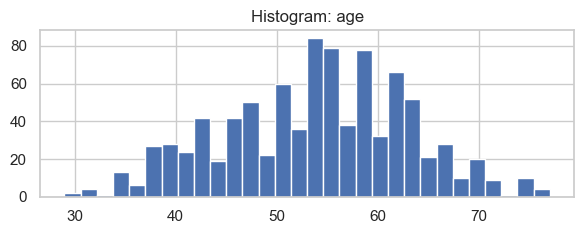

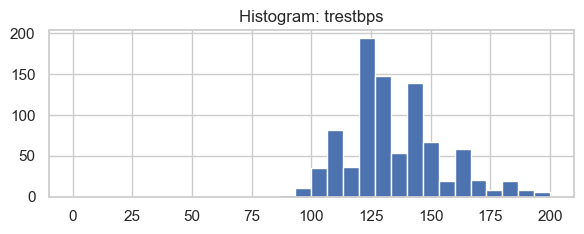

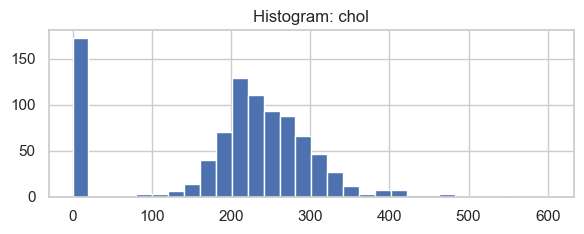

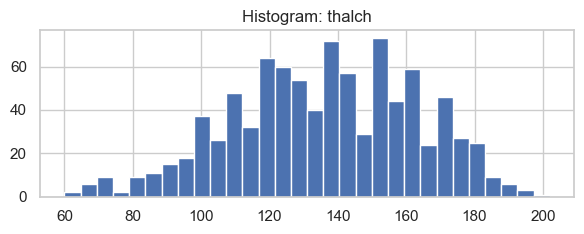

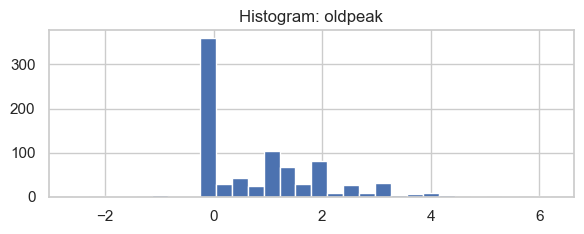

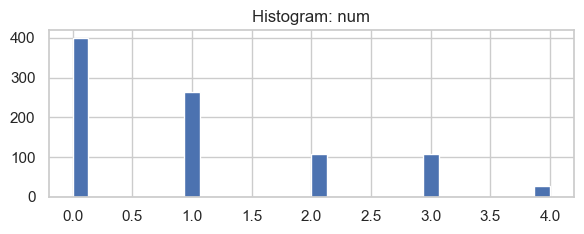

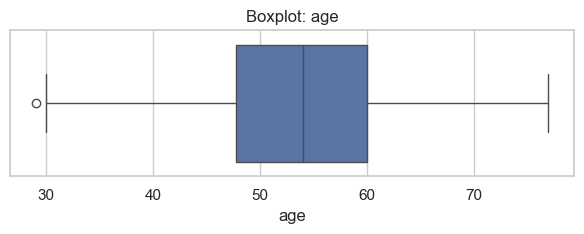

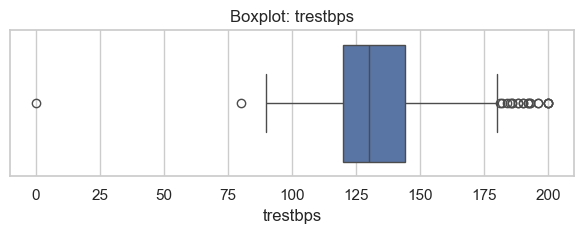

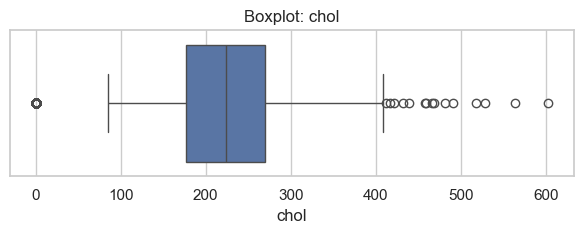

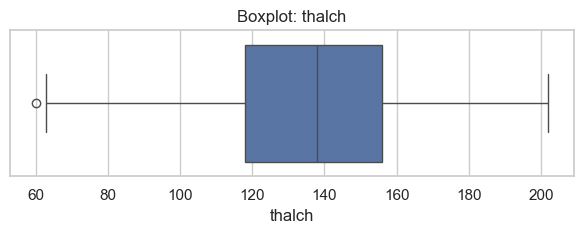

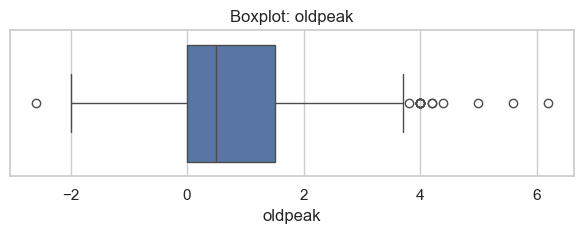

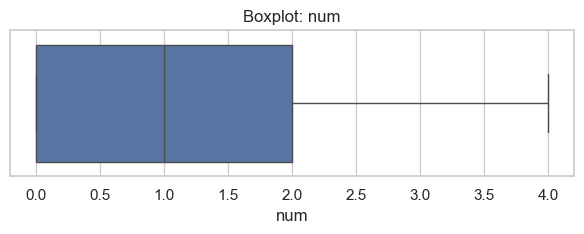

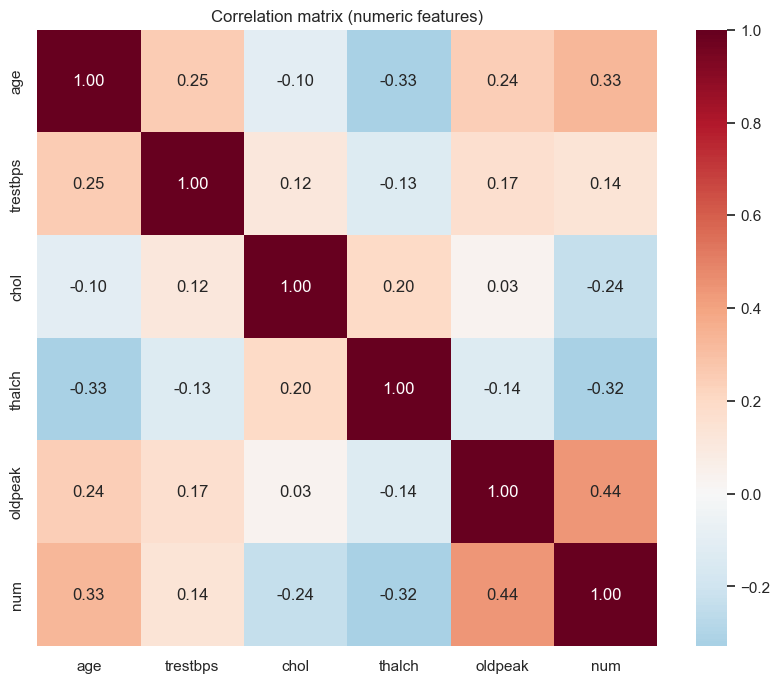

In [2]:
# 2) EDA
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")

print("Data types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())

# Basic stats
display(df.describe(include='all').T)

# Histograms for numeric columns
num_cols = df.select_dtypes(include=['number']).columns.tolist()
print("Numeric columns:", num_cols)

for c in num_cols:
    plt.figure(figsize=(6,2.5))
    plt.hist(df[c].dropna(), bins=30)
    plt.title(f"Histogram: {c}")
    plt.tight_layout()
    plt.show()

# Boxplots for numeric columns (to inspect outliers)
for c in num_cols:
    plt.figure(figsize=(6,2.5))
    sns.boxplot(x=df[c])
    plt.title(f"Boxplot: {c}")
    plt.tight_layout()
    plt.show()

# Correlation matrix heatmap
plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
plt.title("Correlation matrix (numeric features)")
plt.show()


## 3) Feature Engineering
Handle missing values, encode categoricals, and scale numeric features if needed. Decision trees do not require scaling but we show how to do it.

In [3]:
# 3) Feature Engineering & Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
df_proc = df.copy()

# 3a) Handle missing values: simple strategies
for col in df_proc.columns:
    if df_proc[col].dtype == object:
        df_proc[col] = df_proc[col].fillna("Missing").astype(str)
    else:
        df_proc[col] = df_proc[col].fillna(df_proc[col].median())

print("Missing values after imputation:")
display(df_proc.isnull().sum())

# 3b) Detect categorical columns
cat_cols = df_proc.select_dtypes(include=['object','category']).columns.tolist()
num_cols = df_proc.select_dtypes(include=['number']).columns.tolist()
print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

# 3c) Encoding: One-Hot for low-cardinality (<5), Label for >=5
onehot_cols = [c for c in cat_cols if df_proc[c].nunique() < 5]
label_cols = [c for c in cat_cols if df_proc[c].nunique() >= 5]
print("One-hot columns:", onehot_cols)
print("Label columns:", label_cols)

df_enc = df_proc.copy()
# Avoid encoding the target if it's categorical—detect target later
# For now, we'll assume the target column is named commonly; detect it
possible_targets = [c for c in df_enc.columns if c.lower() in ['target','heartdisease','heart_disease','hd','output','diagnosis','class','y']]
if len(possible_targets)==0:
    target_col = df_enc.columns[-1]
    print("No common target name found; assuming last column is target:", target_col)
else:
    target_col = possible_targets[0]
    print("Detected target column:", target_col)

# Separate X and y before encoding to prevent encoding the target
y = df_enc[target_col]
X = df_enc.drop(columns=[target_col])

# One-hot encode low-cardinality columns
if onehot_cols:
    X = pd.get_dummies(X, columns=onehot_cols, drop_first=True, prefix_sep='__')

# Label encode high-cardinality columns
le = LabelEncoder()
for c in label_cols:
    if c in X.columns:  # ensure column present (it might be target originally)
        X[c] = le.fit_transform(X[c].astype(str))

print("Features after encoding shape:", X.shape)
display(X.head())

# 3d) Optional scaling (not necessary for tree but included)
scaler = StandardScaler()
X_scaled = X.copy()
num_in_X = X_scaled.select_dtypes(include=['number']).columns.tolist()
X_scaled[num_in_X] = scaler.fit_transform(X_scaled[num_in_X])
print("Scaling applied to numeric features (for demonstration).")


Missing values after imputation:


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
thal        0
num         0
dtype: int64

Categorical columns: ['sex', 'cp', 'restecg', 'exang', 'slope', 'thal']
Numeric columns: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'num']
One-hot columns: ['sex', 'cp', 'restecg', 'exang', 'slope', 'thal']
Label columns: []
No common target name found; assuming last column is target: num
Features after encoding shape: (908, 19)


age  trestbps  chol    fbs  thalch  oldpeak  sex__Male  \
0   63       145   233   True     150      2.3       True   
1   41       135   203  False     132      0.0       True   
2   57       140   192  False     148      0.4       True   
3   52       118   186  False     190      0.0       True   
4   57       110   201  False     126      1.5       True   

   cp__atypical angina  cp__non-anginal  cp__typical angina  restecg__normal  \
0                False            False                True            False   
1                 True            False               False             True   
2                False            False               False             True   
3                False            False                True            False   
4                False            False               False             True   

   restecg__st-t abnormality  exang__False  exang__TURE  exang__True  \
0                      False          True        False        False   
1                      False          True        False        False   
2                      False          True        False        False   
3                      False          True        False        False   
4                      False         False        False         True   

   slope__flat  slope__upsloping  thal__normal  thal__reversable defect  
0        False             False         False                    False  
1         True             False         False                    False  
2         True             False         False                    False  
3         True             False         False                    False  
4         True             False         False                    False

Scaling applied to numeric features (for demonstration).


## 4) Decision Tree Classification
Split data (80-20), train a DecisionTreeClassifier, and evaluate using accuracy, precision, recall, F1, ROC-AUC.

In [4]:
# 4) Train-Test split and Decision Tree training
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Use X (not scaled) for decision tree (scaling not required)
X_model = X.copy()
# If y is categorical, convert to numeric labels
if y.dtype == object or y.dtype.name == 'category':
    y_encoded = y.astype('category').cat.codes
else:
    y_encoded = y.copy()

# Train-test split; use stratify if binary classification
stratify_arg = y_encoded if (hasattr(y_encoded, 'nunique') and y_encoded.nunique()>1) else None
X_train, X_test, y_train, y_test = train_test_split(X_model, y_encoded, test_size=0.2, random_state=42, stratify=stratify_arg)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
y_proba = None
try:
    if hasattr(dt, 'predict_proba'):
        y_proba = dt.predict_proba(X_test)[:,1] if y_train.nunique()==2 else None
except Exception:
    y_proba = None

# Metrics
if y_encoded.nunique() == 2:
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, zero_division=0))
    print('Recall:', recall_score(y_test, y_pred, zero_division=0))
    print('F1:', f1_score(y_test, y_pred, zero_division=0))
    if y_proba is not None:
        print('ROC-AUC:', roc_auc_score(y_test, y_proba))
else:
    print('Classification report:\n', classification_report(y_test, y_pred))

print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))


Train shape: (726, 19) Test shape: (182, 19)
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.69      0.67        80
           1       0.40      0.36      0.38        53
           2       0.16      0.27      0.20        22
           3       0.33      0.14      0.20        21
           4       0.00      0.00      0.00         6

    accuracy                           0.46       182
   macro avg       0.31      0.29      0.29       182
weighted avg       0.46      0.46      0.45       182


Confusion Matrix:
 [[55 15 10  0  0]
 [16 19 13  3  2]
 [ 7  7  6  1  1]
 [ 4  5  8  3  1]
 [ 2  2  0  2  0]]


## 5) Hyperparameter Tuning
Use GridSearchCV to tune max_depth, min_samples_split, and criterion.

Train class distribution:
num
0    319
1    212
2     87
3     86
4     22
Name: count, dtype: int64

Test class distribution:
num
0    80
1    53
2    22
3    21
4     6
Name: count, dtype: int64


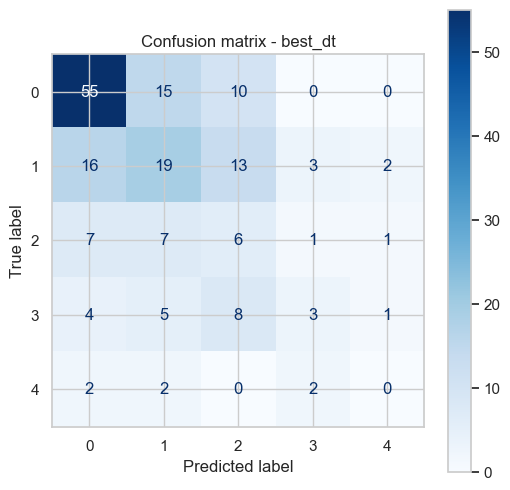

exang__False                 0.457215
chol                         0.233441
age                          0.155929
thalch                       0.113975
oldpeak                      0.039441
restecg__st-t abnormality    0.000000
thal__normal                 0.000000
slope__upsloping             0.000000
slope__flat                  0.000000
exang__True                  0.000000
exang__TURE                  0.000000
cp__typical angina           0.000000
restecg__normal              0.000000
trestbps                     0.000000
cp__non-anginal              0.000000
cp__atypical angina          0.000000
sex__Male                    0.000000
fbs                          0.000000
thal__reversable defect      0.000000
dtype: float64

In [6]:
# 1) Check class distribution
print("Train class distribution:")
print(y_train.value_counts(normalize=False))
print("\nTest class distribution:")
print(y_test.value_counts(normalize=False))

# 2) Confusion matrix (nice view)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=best_dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_dt.classes_)
plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
plt.title("Confusion matrix - best_dt")
plt.show()

# 3) Feature importances quick peek
import pandas as pd
fi = pd.Series(best_dt.feature_importances_, index=X_model.columns).sort_values(ascending=False)
display(fi.head(20))


In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3,5,7,9,12,None],
    'min_samples_split': [2,5,10,20],
    'min_samples_leaf': [1,2,4,8],
    'criterion': ['gini','entropy'],
    'class_weight': [None, 'balanced']
}

grid2 = GridSearchCV(DecisionTreeClassifier(random_state=42),
                     param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid2.fit(X_train, y_train)

print("Best params (f1_macro):", grid2.best_params_)
best_dt2 = grid2.best_estimator_


Best params (f1_macro): {'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 2}


In [8]:
y_pred2 = best_dt2.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred2, zero_division=0))


              precision    recall  f1-score   support

           0       0.65      0.75      0.69        80
           1       0.37      0.42      0.39        53
           2       0.09      0.05      0.06        22
           3       0.32      0.29      0.30        21
           4       0.00      0.00      0.00         6

    accuracy                           0.49       182
   macro avg       0.28      0.30      0.29       182
weighted avg       0.44      0.49      0.46       182



In [9]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

param_dist = {
    'max_depth': [None] + list(range(3,21)),
    'min_samples_split': st.randint(2,40),
    'min_samples_leaf': st.randint(1,20),
    'criterion': ['gini','entropy'],
    'class_weight': [None, 'balanced']
}

rand = RandomizedSearchCV(DecisionTreeClassifier(random_state=42),
                          param_dist, n_iter=60, cv=5, scoring='f1_macro', n_jobs=-1, random_state=42)
rand.fit(X_train, y_train)
print("Randomized best:", rand.best_params_)
best_dt_rand = rand.best_estimator_


Randomized best: {'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 9, 'min_samples_split': 4}


In [11]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print("Resampled distribution:", pd.Series(y_res).value_counts())

dt_sm = DecisionTreeClassifier(random_state=42, class_weight=None)
dt_sm.fit(X_res, y_res)
y_pred_sm = dt_sm.predict(X_test)
print(classification_report(y_test, y_pred_sm, zero_division=0))


Resampled distribution: num
0    319
1    319
2    319
3    319
4    319
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.79      0.68      0.73        80
           1       0.49      0.49      0.49        53
           2       0.14      0.14      0.14        22
           3       0.30      0.48      0.37        21
           4       0.00      0.00      0.00         6

    accuracy                           0.51       182
   macro avg       0.35      0.36      0.35       182
weighted avg       0.54      0.51      0.52       182



In [12]:
# Detailed evaluation and metrics
from sklearn.metrics import precision_recall_fscore_support
prf = precision_recall_fscore_support(y_test, y_pred2, average=None, labels=np.unique(y_test), zero_division=0)
prf_df = pd.DataFrame(prf, index=['precision','recall','f1','support']).T
prf_df.index = np.unique(y_test)
display(prf_df)

# Macro and weighted scores
from sklearn.metrics import f1_score, balanced_accuracy_score
print("F1 macro:", f1_score(y_test, y_pred2, average='macro', zero_division=0))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred2))


precision    recall        f1  support
0   0.645161  0.750000  0.693642     80.0
1   0.372881  0.415094  0.392857     53.0
2   0.090909  0.045455  0.060606     22.0
3   0.315789  0.285714  0.300000     21.0
4   0.000000  0.000000  0.000000      6.0

F1 macro: 0.28942096439206266
Balanced accuracy: 0.2992526341582945


In [13]:
# 5) Hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3,5,7,9,None],
    'min_samples_split': [2,5,10],
    'criterion': ['gini','entropy']
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_dt = grid.best_estimator_

# Evaluate best estimator on test set
y_pred_best = best_dt.predict(X_test)
y_proba_best = None
try:
    if hasattr(best_dt, 'predict_proba') and y_train.nunique()==2:
        y_proba_best = best_dt.predict_proba(X_test)[:,1]
except Exception:
    y_proba_best = None

if y_encoded.nunique() == 2:
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    print('Best model Accuracy:', accuracy_score(y_test, y_pred_best))
    print('Best model Precision:', precision_score(y_test, y_pred_best, zero_division=0))
    print('Best model Recall:', recall_score(y_test, y_pred_best, zero_division=0))
    print('Best model F1:', f1_score(y_test, y_pred_best, zero_division=0))
    if y_proba_best is not None:
        print('Best model ROC-AUC:', roc_auc_score(y_test, y_proba_best))
else:
    from sklearn.metrics import classification_report
    print(classification_report(y_test, y_pred_best))


Best params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.69      0.78      0.73        80
           1       0.37      0.42      0.39        53
           2       0.00      0.00      0.00        22
           3       0.29      0.38      0.33        21
           4       0.00      0.00      0.00         6

    accuracy                           0.51       182
   macro avg       0.27      0.31      0.29       182
weighted avg       0.44      0.51      0.47       182



D:\DATA-SCIENCE\conda_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\DATA-SCIENCE\conda_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\DATA-SCIENCE\conda_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## 6) Model Evaluation & Analysis
Feature importances and tree visualization.

importance
exang__False                 0.457215
chol                         0.233441
age                          0.155929
thalch                       0.113975
oldpeak                      0.039441
restecg__st-t abnormality    0.000000
thal__normal                 0.000000
slope__upsloping             0.000000
slope__flat                  0.000000
exang__True                  0.000000
exang__TURE                  0.000000
cp__typical angina           0.000000
restecg__normal              0.000000
trestbps                     0.000000
cp__non-anginal              0.000000
cp__atypical angina          0.000000
sex__Male                    0.000000
fbs                          0.000000
thal__reversable defect      0.000000

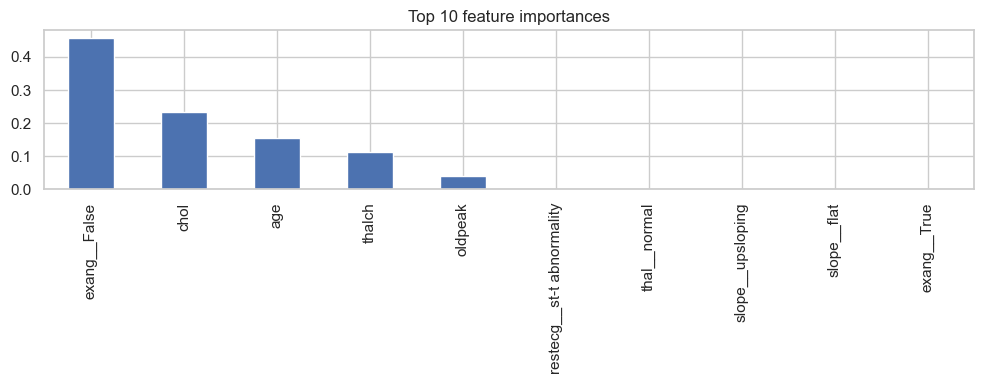

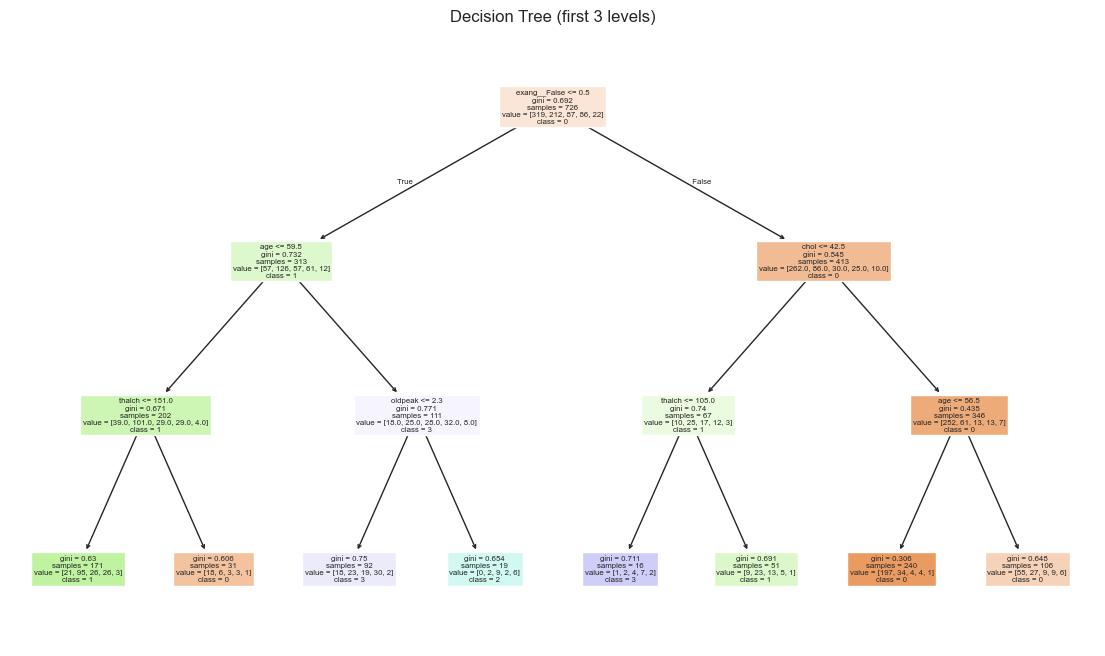

Saved model and processed data to: D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree


In [14]:
# 6) Model interpretation & visualization
import matplotlib.pyplot as plt, numpy as np
from sklearn import tree

# Feature importances
feat_imp = pd.Series(best_dt.feature_importances_, index=X_model.columns).sort_values(ascending=False)
display(feat_imp.head(20).to_frame('importance'))

plt.figure(figsize=(10,4))
feat_imp.head(10).plot(kind='bar')
plt.title('Top 10 feature importances')
plt.tight_layout()
plt.show()

# Plot shallow view of the tree
plt.figure(figsize=(14,8))
tree.plot_tree(best_dt, feature_names=X_model.columns, class_names=[str(c) for c in np.unique(y_encoded)], filled=True, max_depth=3)
plt.title('Decision Tree (first 3 levels)')
plt.show()

# Save model and processed data to local folder
import joblib, os
os.makedirs(r"D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree", exist_ok=True)
model_path = os.path.join(r"D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree", "decision_tree_best_model.joblib")
joblib.dump(best_dt, model_path)
X_model.to_csv(os.path.join(r"D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree", "decision_tree_processed_X.csv"), index=False)
y_encoded.to_csv(os.path.join(r"D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree", "decision_tree_processed_y.csv"), index=False)
print("Saved model and processed data to:", r"D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree")


## Interview Questions — Answers

**1. Common hyperparameters of decision tree models, and how they affect performance:**

- `max_depth`: Maximum depth of the tree. Lower values reduce overfitting but may increase bias. Higher values allow more complex rules but can overfit.
- `min_samples_split`: Minimum number of samples required to split an internal node. Larger values make the tree more conservative.
- `min_samples_leaf`: Minimum number of samples required to be at a leaf node. Prevents tiny leaves and overfitting.
- `criterion`: Function to measure split quality (`gini` or `entropy`). Can slightly change tree shape.
- `max_features`: Number of features considered for splitting; limiting it can reduce variance.

**2. Difference between Label Encoding and One-Hot Encoding:**

- **Label Encoding:** Maps categories to integer labels. Compact but introduces ordinal relationships. Good for tree-based models but risky for linear/distance models.
- **One-Hot Encoding:** Creates binary indicator columns. Preserves non-ordinal nature but increases dimensionality, which can be problematic for high-cardinality features.


### Notebook complete — save & run
Run the notebook locally in `D:\DATA-SCIENCE\ASSIGNMENTS\13 decision tree`. The notebook will save the trained model and processed datasets in that folder.`